In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [2]:
## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/" 
Si_path = datapath + "bananas/Si"
Siabove_path = datapath+ "aboveban/Si"
cuts1 = datapath + "cuts/totcuts.root"
outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

Si_files = glob.glob(os.path.join(Si_path, "*mlio.root"))
Siabove_files = glob.glob(os.path.join(Siabove_path, "*mlio.root"))

In [3]:
#### Loading in of the data files storing them in a dictionary
## 
data_files = {
    "Si": Si_files,
    "Siabove": Siabove_files
}
data_collection = {
    "Si": {},
    "Siabove": {}
}

data_collection = {isotope: {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]} for isotope in data_files}

for isotope, files in data_files.items():
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        mask = (ids==0)
        data_collection[isotope]["E"].extend(Es[mask])
        data_collection[isotope]["fEdep"].extend(fEdeps[mask])
        data_collection[isotope]["bEdep"].extend(bEdeps[mask])
        data_collection[isotope]["angle"].extend(angles[mask])
        data_collection[isotope]["Edep"].extend(Edeps[mask])
        data_collection[isotope]["FI"].extend(FIs[mask])
        data_collection[isotope]["BI"].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Si:   0%|           0/11 [00:00<?, ?file/s]

Processing Si: 100%|██████████ 11/11 [00:14<00:00,  1.30s/file]
Processing Siabove: 100%|██████████ 11/11 [00:04<00:00,  2.64file/s]


In [4]:
## Loading in the cut regions & selecting the data points that lie within the banana cut
totcuts = uproot.open(cuts1)

xa, ya = totcuts["abovebanU1"].values()
xa = xa/1e3
ya = ya/1e3
xb, yb = totcuts["bananaU1"].values()
xb = xb/1e3
yb = yb/1e3

 
inbanana = np.column_stack((xb, yb))#(iis[0], js[0]))
inbanana_path = Path(inbanana)


isotope = "Si"

points = np.column_stack((data_collection[isotope]["bEdep"], data_collection[isotope]["fEdep"]))
inmask = inbanana_path.contains_points(points)

in_fedep = np.array(data_collection[isotope]["fEdep"])[inmask]
in_bedep = np.array(data_collection[isotope]["bEdep"])[inmask]
in_E = np.array(data_collection[isotope]["E"])[inmask]


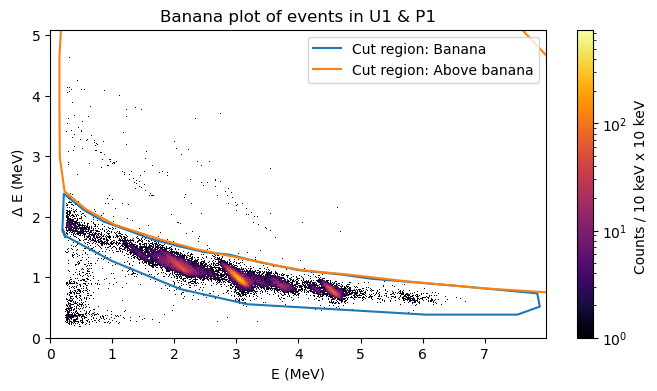

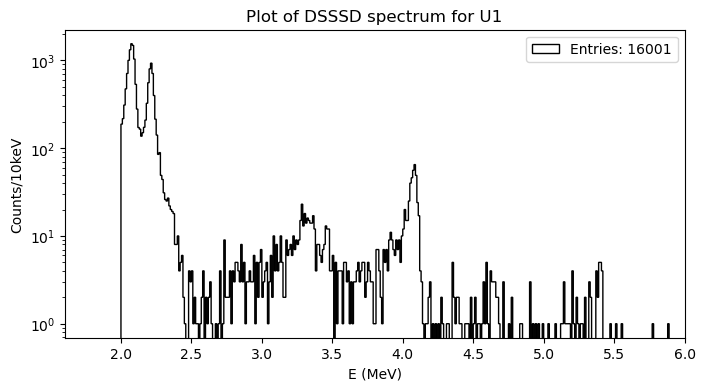

In [ ]:
##Plot of the cut regions
plt.figure(figsize=(8,4))
iso = "Si"

plt.hist2d(data_collection[iso]["bEdep"], data_collection[iso]["fEdep"], bins=(np.arange(0, 8, 0.01), np.arange(0, 5.1, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel("E (MeV)")
plt.ylabel(r" $\Delta$ E (MeV)")
plt.plot(xb, yb, label="Cut region: Banana")
plt.plot(xa, ya, label="Cut region: Above banana")
plt.legend(loc='upper right')
plt.title("Banana plot of events in U1 & P1")
plt.savefig(outputdir + "bananaplot.png")

## Plot of the energy deposited in the DSSSD detector where no telescope events have been matched
plt.figure(figsize=(8,4))
h = [j for j in data_collection[iso]["Edep"] if j>2]
plt.hist(h, bins=np.arange(0,7,0.01), histtype='step', color='k', label=f"Entries: {len(h)}")
plt.legend(loc='upper right')
plt.yscale('log')
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10keV")
plt.title("Plot of DSSSD spectrum for U1")
plt.xlim(1.6, 6)
#plt.savefig(outputdir + "dsssdspec.png")


Entries in cut region in banana:  114123
Entries in cut region above banana:  523




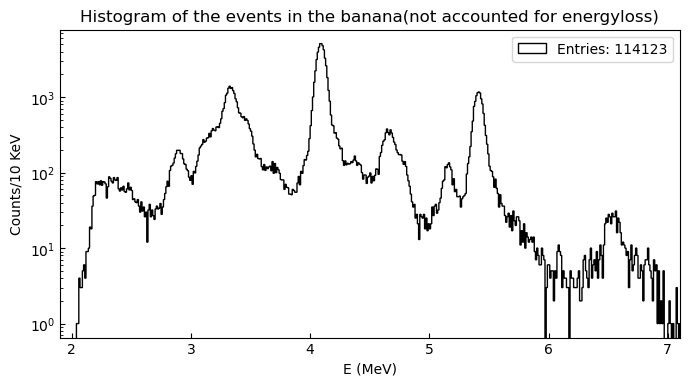

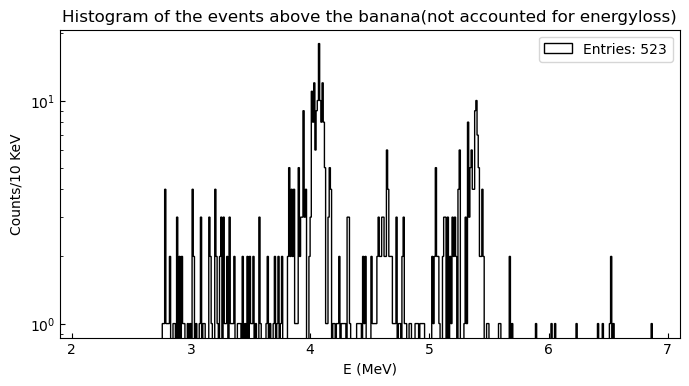

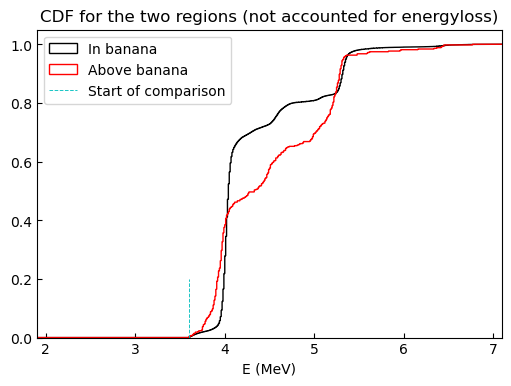

In [6]:
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

### Plot of histogram of the events recorded inside the banana
bin_width = 0.01 # keV
bins = np.arange(0, 9 + bin_width, bin_width)
sumE = [a+b for a,b in zip(in_fedep, in_bedep)]
plt.figure(figsize=(8,4))
plt.hist(in_E, bins=bins, histtype='step', color='k', label=f"Entries: {len(in_E)}")
plt.yscale('log')
print("Entries in cut region in banana: ",len(in_fedep))
plt.title("Histogram of the events in the banana(not accounted for energyloss)")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')
plt.savefig(outputdir + "bananahist.png")

#plt.show()
g = len(data_collection["Siabove"]["E"])
#plot of events recorded above the banana
sume = [a+b for a,b in zip(data_collection["Siabove"]["fEdep"], data_collection["Siabove"]["bEdep"])]
plt.figure(figsize=(8,4))
plt.hist(data_collection["Siabove"]["E"], bins=bins, histtype='step', color='k', label=f"Entries: {g}")
plt.yscale('log')
print("Entries in cut region above banana: ", len(data_collection["Siabove"]["fEdep"]))
plt.title("Histogram of the events above the banana(not accounted for energyloss)")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9,7.1)
plt.legend(loc='upper right')
plt.savefig(outputdir + "abovehist.png")

print()

fbE = [a+b for a,b in zip(in_fedep, in_bedep) if a+b>3.6]
fbe = [a+b for a,b in zip(data_collection["Siabove"]["fEdep"], data_collection["Siabove"]["bEdep"]) if a+b>3.6]

#The CDF for the two histograms
plt.figure(figsize=(6,4))
plt.hist(fbE, bins=bins, histtype='step', color='k', cumulative=True, label="In banana", density=True)
plt.hist(fbe, bins=bins, histtype='step', color='r', cumulative=True, label="Above banana", density=True)
plt.vlines(3.6, 0, 0.2, color='c', alpha=0.9, lw=0.7, ls='--', label="Start of comparison")
plt.xlabel("E (MeV)")
plt.legend(loc='upper left')
plt.xlim(0,8.5)
plt.xticks(np.arange(0,9,1))
plt.title("CDF for the two regions (not accounted for energyloss)")
plt.xlim(1.9, 7.1)
plt.savefig(outputdir + "CDFbefore.png")
print()

271


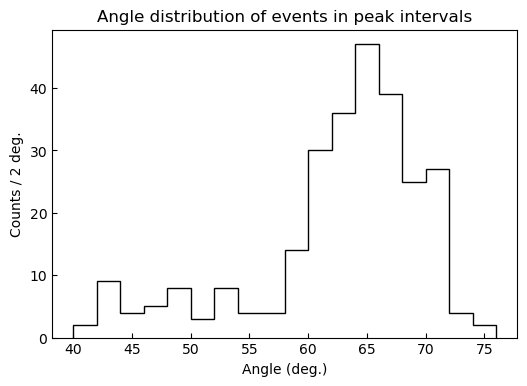

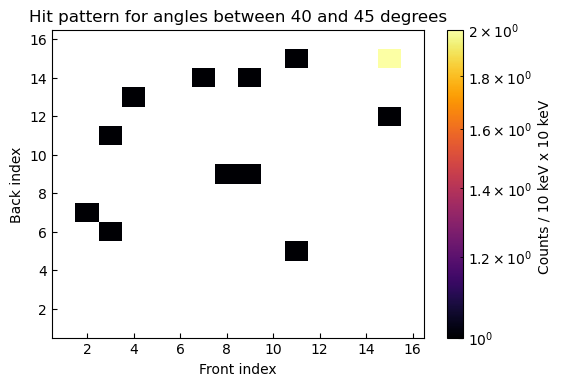

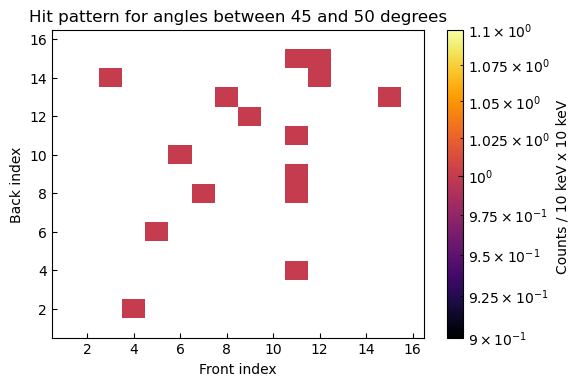

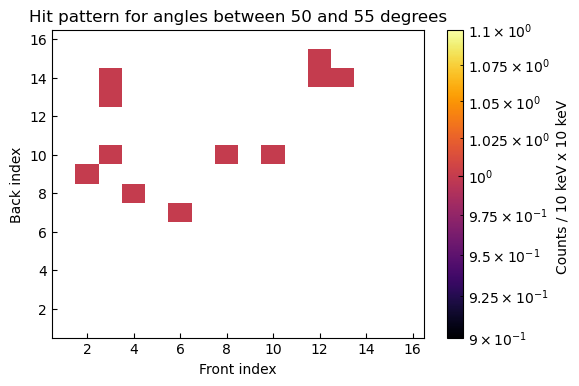

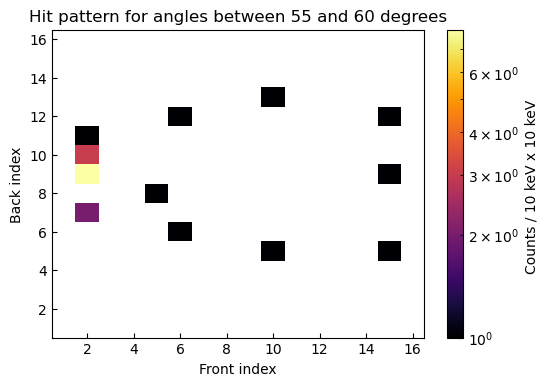

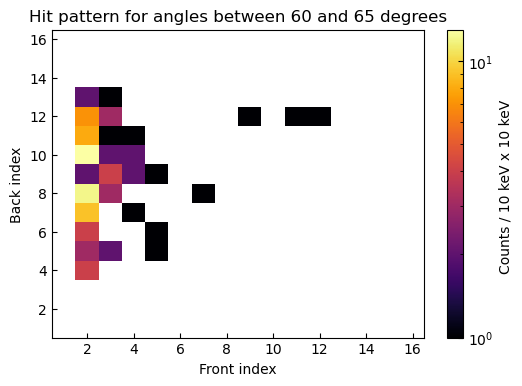

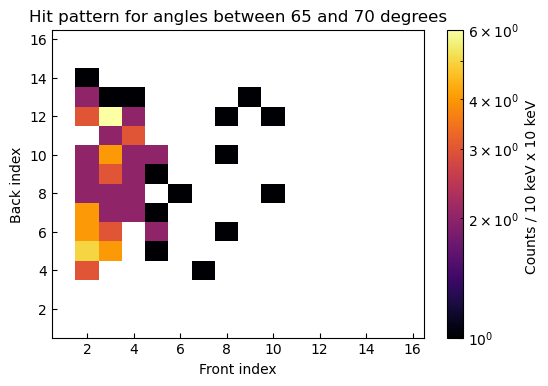

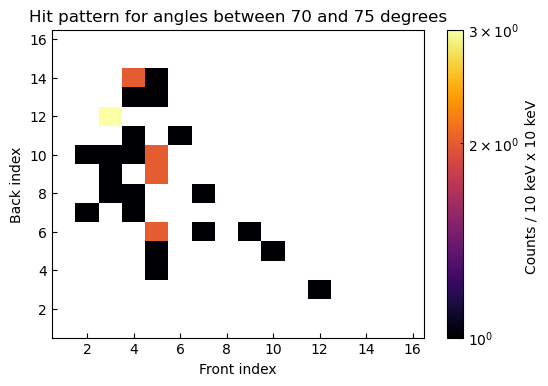

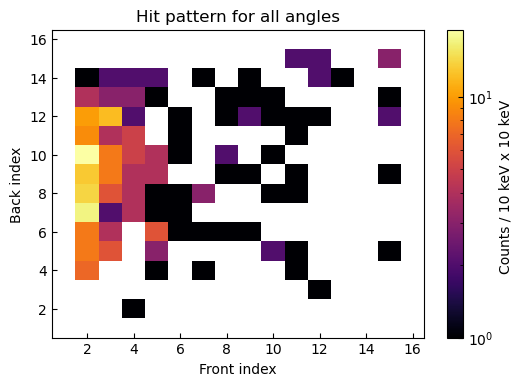

In [7]:
### Plot of the angle distribution of the recorded events that we can attribute to specific peaks above the banana

angles = np.array(data_collection["Siabove"]["angle"])
mask = (angles>0)
fi = np.array(data_collection["Siabove"]["FI"])[mask]
bi = np.array(data_collection["Siabove"]["BI"])[mask]
angles = angles[mask]
e_withangles = np.array(data_collection["Siabove"]["E"])[mask]
uncor_fe = np.array(data_collection["Siabove"]["fEdep"])[mask]
uncor_be = np.array(data_collection["Siabove"]["bEdep"])[mask]

plt.figure(figsize=(6,4))
plt.hist(angles, bins=np.arange(40,78, 2), histtype='step', color='k', label=f"Entries: {len(angles)}")
plt.xlabel("Angle (deg.)")
plt.ylabel("Counts / 2 deg.")
plt.title("Angle distribution of events in peak intervals")
print(len(angles))
plt.savefig(outputdir + "angledist.png")


##### Plots of the hitpatterns for each interval of 5 degrees
#40-76 degrees
for i in range(45, 77, 5):
    f = [c-0.5 for c,a in zip(fi,angles) if i-5<=a<=i]
    b = [c-0.5 for c,a in zip(bi,angles) if i-5<=a<=i]
    plt.figure(figsize=(6,4))
    plt.hist2d(f, b, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    plt.title(f"Hit pattern for angles between {i-5} and {i} degrees")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    
##Lastly a total hitpattern for the events
plt.figure(figsize=(6,4))
plt.hist2d(fi, bi, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.title(f"Hit pattern for all angles")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')
plt.savefig(outputdir + "hitpat.png")


Entries in cut region in banana:  114123
Entries in cut region above banana:  523




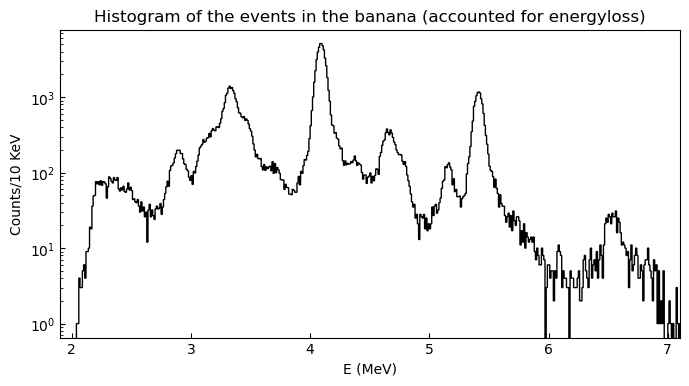

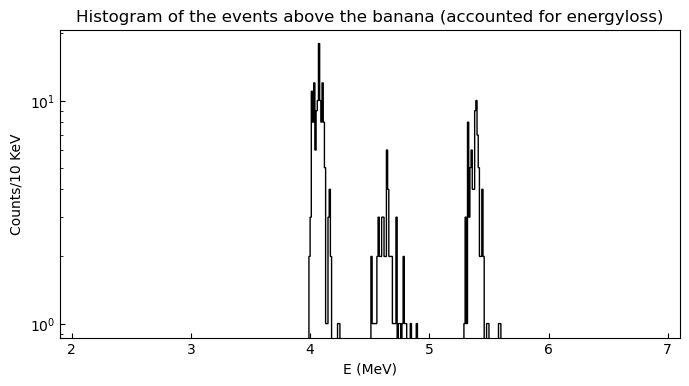

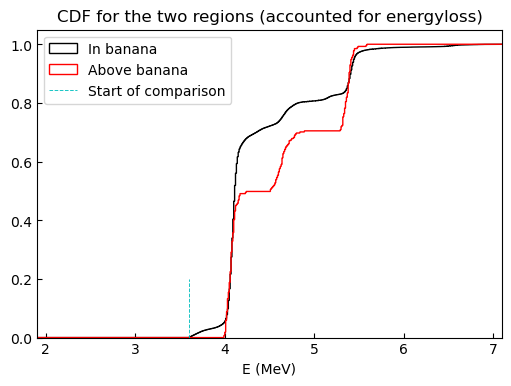

In [8]:
### The same plots of the histograms and CDF as earlier, now we have accounted for the energyloss due to the
### larger angles of incidence. 


plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

bin_width = 0.01 # keV
bins = np.arange(0, 9 + bin_width, bin_width)
sumE = [a+b for a,b in zip(in_fedep, in_bedep)]
plt.figure(figsize=(8,4))
plt.hist(in_E, bins=bins, histtype='step', color='k', label=f"Entries: {in_E}")
plt.yscale('log')
print("Entries in cut region in banana: ",len(in_fedep))
plt.title("Histogram of the events in the banana (accounted for energyloss)")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9, 7.1)
plt.savefig(outputdir + "bananahistafter.png")

#plt.show()

sume = [a+b for a,b in zip(data_collection["Siabove"]["fEdep"], data_collection["Siabove"]["bEdep"])]
plt.figure(figsize=(8,4))
plt.hist(e_withangles, bins=bins, histtype='step', color='k', label=f"Entries: {e_withangles}")
plt.yscale('log')
print("Entries in cut region above banana: ", len(data_collection["Siabove"]["fEdep"]))
plt.title("Histogram of the events above the banana (accounted for energyloss)")
plt.xlabel("E (MeV)")
plt.ylabel("Counts/10 KeV")
plt.xticks(np.arange(0,9, 1))
plt.xlim(1.9, 7.1)
plt.savefig(outputdir + "abovehistafter.png")

print()


plt.figure(figsize=(6,4))
aboveE = [e for e in in_E if e>3.6]
abovee = [e for e in e_withangles if e>3.6]
plt.hist(aboveE, bins=bins, histtype='step', color='k', cumulative=True, label="In banana", density=True)
plt.hist(abovee, bins=bins, histtype='step', color='r', cumulative=True, label="Above banana", density=True)
plt.vlines(3.6, 0, 0.2, color='c', alpha=0.9, lw=0.7, ls='--', label="Start of comparison")
plt.xlabel("E (MeV)")
plt.legend(loc='upper left')
plt.xticks(np.arange(0,9,1))

plt.xlim(1.9,7.1)
plt.title("CDF for the two regions (accounted for energyloss)")
plt.savefig(outputdir + "CDFafter.png")

print()


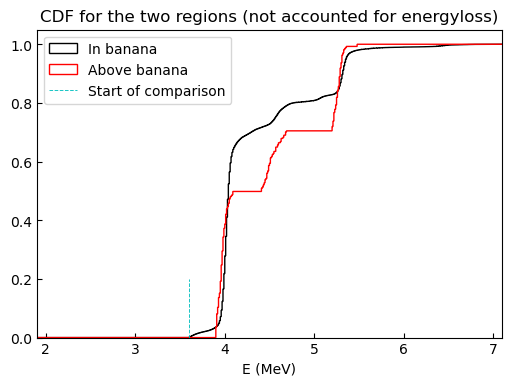

In [9]:
fbE = [a+b for a,b in zip(in_fedep, in_bedep) if a+b>3.6]
fbe = [a+b for a,b in zip(uncor_fe, uncor_be) if a+b>3.6]

#The CDF for the two histograms
plt.figure(figsize=(6,4))
plt.hist(fbE, bins=bins, histtype='step', color='k', cumulative=True, label="In banana", density=True)
plt.hist(fbe, bins=bins, histtype='step', color='r', cumulative=True, label="Above banana", density=True)
plt.vlines(3.6, 0, 0.2, color='c', alpha=0.9, lw=0.7, ls='--', label="Start of comparison")
plt.xlabel("E (MeV)")
plt.legend(loc='upper left')
plt.xlim(0,8.5)
plt.xticks(np.arange(0,9,1))
plt.title("CDF for the two regions (not accounted for energyloss)")
plt.xlim(1.9, 7.1)
plt.savefig(outputdir + "CDFbefore(peaks).png")
print()

## The small tail is likely from not including the contact thickness of the detectors in the analysis